# Text Classification with Albert-Persian
> Text Classification with Transformers-LMs in TF 2.X & PyTorch 
- toc: true
- branch: master
- badges: true
- comments: true
- image: images/albert.png
- author: Sajjad Ayoubi
- categories: [nlp, jupyter]


## What's ALBERT-Persian?

A Lite BERT for Self-supervised Learning of Language Representations for the Persian Language<br>
- thanks [Mehrdad Farahani](https://github.com/m3hrdadfi) & [Hoshvare](https://hooshvare.com/) for sharing this
[albert-persian repo](https://github.com/m3hrdadfi/albert-persian)

ALBERT-Persian trained on a massive amount of public corpora (Persian Wikidumps, MirasText) and six other manually crawled text data from a various type of websites (BigBang Page scientific, Chetor lifestyle, Eligasht itinerary, Digikala, Ted Talks general conversational, Books novels, storybooks, short stories from old to the contemporary era).

# Dataset (DigiMag)
 - For this notebook, I'm going to use DigiMag dataset for text classification
    - train len: **6865**  , valid len:**767** , test len: **852**
    - it has **7** types for Magazines (7 classes)
    - thanks [Hooshvare](https://hooshvare.com/) for sharing this

- this is an example of how to use (You can use whatever dataset you have)

- the training was on Google Colab

In [ ]:
!nvidia-smi

Thu Feb 18 05:45:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install required packages for model
!pip install -q sentencepiece
!pip install -q transformers
!pip install -q tokenizers
# for text processing
!pip -q install hazm
!pip -q install clean-text[gpl]

     |████████████████████████████████| 1.2MB 5.9MB/s 
     |████████████████████████████████| 1.8MB 6.1MB/s 
     |████████████████████████████████| 3.2MB 40.2MB/s 
     |████████████████████████████████| 890kB 38.7MB/s 
     |████████████████████████████████| 317kB 5.0MB/s 
     |████████████████████████████████| 1.4MB 5.4MB/s 
     |████████████████████████████████| 235kB 17.9MB/s 
     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 133kB 7.0MB/s 
     |████████████████████████████████| 245kB 6.9MB/s 


In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm 

from hazm import Normalizer
from hazm import WordTokenizer
from cleantext import clean
import re

## Load
  - the dataset is [here](https://bit.ly/3ca4bm8) on Drive (open it with VPN)
  - add it on your drive and use it like the following

In [ ]:
# mount the google drive and change current dir
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive

Mounted at /gdrive
/gdrive/MyDrive


In [ ]:
# unzip the dataset in your drive
!unzip digimag.zip

Archive:  digimag.zip
   creating: digimag/
  inflating: digimag/dev.csv         
  inflating: digimag/train.csv       
  inflating: digimag/test.csv        


-  load train, test, and valid with Pandas

In [ ]:
train_df = pd.read_csv('digimag/train.csv', delimiter="	", index_col=False)
eval_df = pd.read_csv('digimag/dev.csv', delimiter="	", index_col=False)
test_df = pd.read_csv('digimag/test.csv', delimiter="	", index_col=False)

# drop the label columns
train_df.drop(columns=['Unnamed: 0', 'label'], inplace=True)
eval_df.drop(columns=['Unnamed: 0', 'label'], inplace=True)
test_df.drop(columns=['Unnamed: 0', 'label'], inplace=True)
train_df.head()

,content,label_id
0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,3
1,شکست Justice League در باکس آفیس پس از بازخورد...,5
2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,5
3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,3
4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,0


## Normalization (Preprocessing)


Our cleaning method includes these steps:

- fixing unicodes
- removing specials like a phone number, email, url, new lines, ...
- cleaning HTMLs
- normalizer
- tokenize and detokenize (for adding space)

In [ ]:
# for more details see hazm doc
tokenizer = WordTokenizer(join_verb_parts=False, replace_hashtags=False, replace_IDs=False)
normalizer = Normalizer(remove_extra_spaces=True, persian_numbers=False, persian_style=True,
                        punctuation_spacing=False, remove_diacritics=True,
                        affix_spacing=False, token_based=True)

def cleaning(text):
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=True,
        no_digits=True,
        no_currency_symbols=True,
        no_punct=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_currency_symbol="")
    
    text = re.sub(r'([ا-ی])\1{2,}', r'\1', text) # bbb+ -> b at least 2 char
    return text.strip()

def text_preprocessor(t, tokenize=False):
  tokens = tokenizer.tokenize(cleaning(normalizer.normalize(t)))
  return tokens if tokenize else ' '.join(tokens)

In [ ]:
# clean test set and valid set
test_df['cleaned'] = test_df.content.apply(text_preprocessor)
print('test cleaned')
eval_df['cleaned'] = eval_df.content.apply(text_preprocessor)
print('valid cleaned')

test cleaned
valid cleaned


In [ ]:
# clean and tokenize train set
train_df['cleaned'] = train_df.content.apply(text_preprocessor)
print('train cleaned')
train_df['tokens'] = train_df.content.apply(text_preprocessor, tokenize=True)
train_df.head(3)

train cleaned


,content,label_id,cleaned,tokens
0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,3,نمایش تبلیغ در لاک اسکرین تعدادی از گوشی های ه...,"[نمایش, تبلیغ, در, لاک, اسکرین, تعدادی, از, گو..."
1,شکست Justice League در باکس آفیس پس از بازخورد...,5,شکست justice league در باکس آفیس پس از بازخورد...,"[شکست, justice, league, در, باکس, آفیس, پس, از..."
2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,5,کلاسیک بینی همه چیز در یک شب اتفاق افتاد فیلم ...,"[کلاسیک, بینی, همه, چیز, در, یک, شب, اتفاق, اف..."


### display the frequent words in the train set

number of words 80154


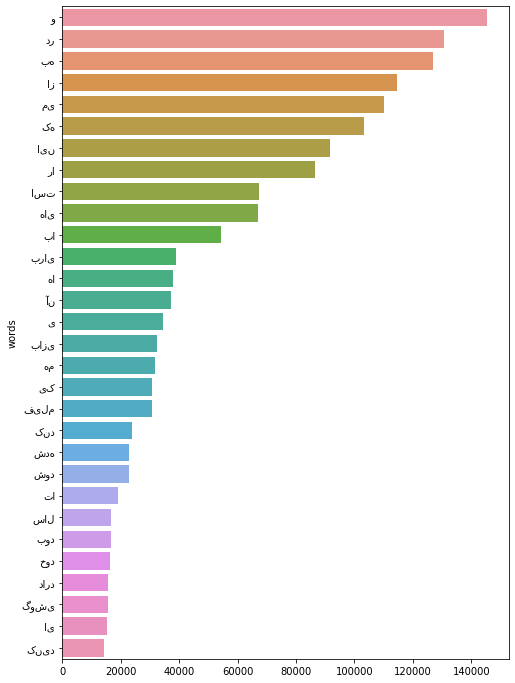

In [ ]:
word_list = []
for s in train_df.tokens:
    for w in s:
        word_list.append(w)

words = pd.DataFrame(word_list, columns=['words'])
top = words.groupby(['words']).size().sort_values(ascending=False)
print('number of words', len(top.index))
plt.figure(figsize = (8,12))
sns.barplot(x=top.values[:30], y=top.index[:30]);

### Finding the max len
The contents have different lengths based on words! Detecting the most normal range could help us find the maximum length of the sequences for the preprocessing step. On the other hand, we suppose that the minimum word combination for having a meaningful article for our learning process is 50.

In [ ]:
# compute the words len in each magazine
train_df['words_len'] = train_df.tokens.apply(lambda t: len(t))

In [ ]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='words_len'):
    data_length = data[col].values
    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])
    data_glt_rate = (data_glt / len(data_length)) * 100
    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

data_gl_than(train_df, 1e4, 50)   

Texts with word length of greater than 50 and less than 10000.0 includes 99.55% of the whole!


In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train_df['words_len']))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
minlim, maxlim = 50, 1e4
# remove comments with the length of fewer than 50 words
print('size of the data before remove: ', len(train_df))
train_df['words_len'] = train_df['words_len'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
train_df = train_df.dropna(subset=['words_len'])
train_df = train_df.reset_index(drop=True)
print('size of the data after remove: ', len(train_df))

size of the data before remove:  6896
size of the data after remove:  6865


### Distribution of Classes

In [ ]:
fig = go.Figure()
topic_freq = train_df.label_id.value_counts()
fig.add_trace(go.Bar(y=topic_freq, x=topic_freq.index.to_numpy()))
fig.update_layout(
    title_text='Distribution of each class',
    xaxis_title_text='classes',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

## Prepare data for Albert-LM
  - using transformers tokenizer
  - tiny and fast BERT-ish Language Model (just 70MB)
    - the pre-trained model is from [Merhdad Farhani](https://github.com/m3hrdadfi/albert-persian)

- this is the latest version from official repository
- the new version removes half-space and newlines in its tokenizer (you don't have to handle it in your cleaning)

In [ ]:
batch_size = 16
max_len = 256
class_number = 7
# this is the latest version from official repository
model_name = "HooshvareLab/albert-fa-zwnj-base-v2"

In [ ]:
from transformers import AlbertTokenizerFast
tokenizer = AlbertTokenizerFast.from_pretrained(model_name)

- Tokenization

In [ ]:
train_encodings = tokenizer(train_df.cleaned.tolist(), max_length=max_len, truncation=True, padding=True)
print('train tokenized')
test_encodings = tokenizer(test_df.cleaned.tolist(), max_length=max_len, truncation=True, padding=True)
print('test tokenized')
valid_encodings = tokenizer(eval_df.cleaned.tolist(), max_length=max_len, truncation=True, padding=True)
print('valid tokenized')

train tokenized
test tokenized
valid tokenized


- create config for our classification task

In [ ]:
from transformers import AutoConfig

# create a dict for classes
label2id = {label: i for i, label in enumerate(range(class_number))}
id2label = {v: k for k, v in label2id.items()}
config = AutoConfig.from_pretrained(model_name,**{'label2id': label2id, 'id2label': id2label})

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')


label2id: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
id2label: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


# Training

## PyTorch

In [ ]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from transformers import AlbertForSequenceClassification
# set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class DigiMagDs(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# create datasets
train_ds = DigiMagDs(train_encodings, train_df.label_id)
valid_ds = DigiMagDs(valid_encodings, eval_df.label_id)
test_ds = DigiMagDs(test_encodings, test_df.label_id)

# create Dataloders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

- My PyTorch Trainer

In [ ]:
import time, sys
from IPython.display import clear_output

class TorchTrainer:
    def __init__(self, model, train_dl, valid_dl, optimizer):
        self.model = model
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.optimizer = optimizer
        self.loss_history = []

    def fit(self, num_epochs):
        clear_output()
        valid_acc = 0
        for epoch in range(num_epochs):
            print('Epoch %2d/%2d' % (epoch + 1, num_epochs))
            print('-' * 20)
            t0 = time.time()
            train_acc = self.train_model()
            valid_acc = self.valid_model()
            time_elapsed = time.time() - t0
            print('\n Metrics: | train_acc: %.3f | valid_acc: %.3f |' % (train_acc[0], valid_acc[0]))
            print('\n  Epoch complete in: %.0fm %.0fs \n' % (time_elapsed // 60, time_elapsed % 60))
        return

    def train_model(self):
        self.model.train()
        N = len(self.train_dl.dataset)
        step = N // self.train_dl.batch_size
        avg_loss = 0.0
        avg_acc = 0.0
        for i, batch in enumerate(self.train_dl):
            self.optimizer.zero_grad()
            # forward
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
            predictions = torch.argmax(outputs['logits'], dim=1)
            # loss
            loss = outputs['loss']
            # backward
            loss.backward()
            self.optimizer.step()
            # statistics of model training and print
            avg_loss = (avg_loss * i + loss) / (i + 1)
            avg_acc += torch.sum(predictions == labels)
            self.loss_history.append(avg_loss)
            sys.stdout.flush()
            sys.stdout.write("\r  Train_Step: %d/%d | runing_loss: %.4f" % (i + 1, step, avg_loss))

        sys.stdout.flush()
        return torch.tensor([avg_acc]) / N

    def valid_model(self):
        print()
        self.model.eval()
        N = len(self.valid_dl.dataset)
        step = N // self.valid_dl.batch_size
        avg_loss = 0.0
        avg_acc = 0.0
        with torch.no_grad():
            for i, batch in enumerate(self.valid_dl):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                predictions = torch.argmax(outputs['logits'], dim=1)
                loss = outputs['loss']
                avg_loss = (avg_loss * i + loss) / (i + 1)
                avg_acc += torch.sum(predictions == labels)
                sys.stdout.flush()
                sys.stdout.write("\r  Valid_Step: %d/%d | runing_loss: %.4f" % (i, step, avg_loss))

        sys.stdout.flush()
        return torch.tensor([avg_acc]) /N

In [ ]:
model = AlbertForSequenceClassification.from_pretrained(model_name, config=config)
model.to(device)
# AdamW is just adam with fixing on weight decay (don't worry about it)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.0)

Some weights of the model checkpoint at HooshvareLab/albert-fa-zwnj-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/albert-fa-zwnj-base-v2 and are newly initialized: ['albe

In [ ]:
trainer = TorchTrainer(model, train_dl, valid_dl, optimizer=optimizer)
trainer.fit(num_epochs=2)

Epoch  1/ 2
--------------------
  Train_Step: 427/426 | runing_loss: 0.3749
  Valid_Step: 47/47 | runing_loss: 0.2160
 Metrics: | train_acc: 0.893 | valid_acc: 0.941 |

  Epoch complete in: 11m 4s 

Epoch  2/ 2
--------------------
  Train_Step: 427/426 | runing_loss: 0.2136
  Valid_Step: 47/47 | runing_loss: 0.2005
 Metrics: | train_acc: 0.942 | valid_acc: 0.935 |

  Epoch complete in: 10m 55s 



- We achieve 94% just in 2 epochs 
  - and without any hyperparameters optimization
  - Not bad ha?

## Tensorflow

In [ ]:
from transformers import TFAlbertForSequenceClassification
import tensorflow as tf

- creat tf_dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df.label_id))
train_ds = train_ds.shuffle(1024).batch(batch_size, drop_remainder=True)
print('train dataset created')

test_ds = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df.label_id))
test_ds = test_ds.shuffle(512).batch(batch_size, drop_remainder=True)
print('test dataset created')

valid_ds = tf.data.Dataset.from_tensor_slices((dict(valid_encodings), eval_df.label_id))
valid_ds = valid_ds.shuffle(512).batch(batch_size, drop_remainder=True)
print('valid dataset created')

train dataset created
test dataset created
valid dataset created


- the original model is based on PyTorch
- If you need use Albert-Persian in TF you have to use `from_pt=True`

In [ ]:
# load model
model = TFAlbertForSequenceClassification.from_pretrained(model_name, config=config, from_pt=True)
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['acc']) # you can also use any keras loss fn
model.summary()

Model: "tf_albert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  11683584  
_________________________________________________________________
dropout_18 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  5383      
Total params: 11,688,967
Trainable params: 11,688,967
Non-trainable params: 0
_________________________________________________________________


In [ ]:
H = model.fit(train_ds, validation_data=valid_ds, epochs=2, batch_size=batch_size)

Epoch 1/2
426/426 [==============================] - 920s 2s/step - loss: 0.5785 - acc: 0.8232 - val_loss: 0.2331 - val_acc: 0.9295
Epoch 2/2
426/426 [==============================] - 875s 2s/step - loss: 0.2243 - acc: 0.9400 - val_loss: 0.1981 - val_acc: 0.9348


In [ ]:
# get result on Test set
metrics = model.evaluate(test_ds)
print('test loss: ', metrics[0])
print('test acc: ', metrics[1])

53/53 [==============================] - 30s 562ms/step - loss: 0.2437 - acc: 0.9387
test loss:  0.2437356561422348
test acc:  0.9386792182922363


## How can we achieve better results
- with hyper parameters tuning
  - more epoch
  - different batch size
  - bigger max len 
  - ...

## HuggingFace 🤗
- you can also train it with HuggingFace Trainer & TFTrainer
- for more details see [this](https://huggingface.co/transformers/main_classes/trainer.html)

# In The End
- thanks for your attention
- sorry, my English is not great but you can get the idea
- write your comments and ideas below
  - and say about my mistakes or ...